In [1]:
import sys, os
#from copy import deepcopy
from importlib import reload

import numpy as np
import itertools
from itertools import combinations
from fractions import Fraction

import scipy as sp
import scipy.stats as st
from scipy import interpolate 
import copy

import pandas as pd

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

import seaborn as sns

import tqdm
import time
import csv
import math

import MPL
import MPL_virus


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

AA  = sorted(['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I','L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '*'])

virus glue

In [2]:
def virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT):

    estimate_selection, regularization_list = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
#     REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
    correlation_list = optimize_regularization_virus(estimate_selection, REPLICATES, regularization_list)
    
    plot_reg_corr(regularization_list, correlation_list, TARGET_PROTEIN)

    REGULARIZATION_SELECTED = find_best_regularization(regularization_list, correlation_list, REGULARIZATION_PERCENT)


    FINAL_SELECTION = output_final_selection_virus(REGULARIZATION_SELECTED, SITE_END, SITE_START, estimate_selection, REPLICATES)
    
    if os.path.exists(OUTPUT_DIR):
        FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')
    else:
        os.makedirs(OUTPUT_DIR)
        FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')

def optimize_regularization_virus(estimate_selection, REPLICATES, REGULARIZATION_LIST):
    correlation_list = []
    for regular in REGULARIZATION_LIST:
        temp_sele=[]
        temp_corr = []
        for replicate in REPLICATES:
            temp_sele.append(estimate_selection[str(replicate)][regular])
        for pairs in list(combinations(temp_sele, 2)):
            temp_corr.append(st.pearsonr(pairs[0], pairs[1])[0])
        correlation_list.append(np.mean(temp_corr))
    return correlation_list


def cov_inverse(cov, L, q, regular):
    cov_temp = cov.copy()
    for i in range(L):
#         print("Computing covariance matrix...%.1f%%/100%% completed"%(float((i+1)/L)*100),end='\r')
        for a in range(q):
            cov_temp[(q * i) + a, (q * i) + a] += regular  # diagonal regularization
    
    for i in range(L):
        cov_block = np.zeros((q, q))
        for a in range(q):
            for b in range(q):
                cov_block[a, b] = cov_temp[(q * i) + a, (q * i) + b]

        cov_block = np.linalg.inv(cov_block)

        for a in range(q):
            for b in range(q):
                cov_temp[(q * i) + a, (q * i) + b] = cov_block[a, b]

    return cov_temp



def output_final_selection_virus(REGULARIZATION_SELECTED, SITE_END, SITE_START, estimate_selection, REPLICATES):
    
    site_list = []
    for site in range(SITE_END-SITE_START+1):
        site_list+=[site]*21
    AA_list = AA*(SITE_END-SITE_START+1)
    rep_list = []
    for replicate in REPLICATES:
        rep_list.append('rep_'+str(replicate))
    df_selection = pd.DataFrame(columns=['site', 'amino_acid']+rep_list)
    df_selection['site'] = site_list
    df_selection['amino_acid'] = AA_list
    for replicate in REPLICATES:
        df_selection['rep_'+str(replicate)] = estimate_selection[str(replicate)][REGULARIZATION_SELECTED]
    return df_selection   
        
def MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR):
    # DATA_DIR = 'data_' + TARGET_PROTEIN
    print('------ Calculating single replicate selection coefficients for %s ------' %TARGET_PROTEIN)
    print("\nCalculating error probability from %s...\n" %DNACODON)

    err = MPL_virus.err_correct(INPUT_DIR, DNACODON)
    estimate_selection = {}
    
    minimum = sys.float_info.max

    for run_name in REPLICATES:
        run_name = str(run_name)
        estimate_selection[run_name]={}
        func_para = {
            'MPL_DIR':      MPL_DIR,                                             # MPL directory
            'DMS_DIR':      INPUT_DIR,                                             # DMS directory
            'PRE_FILE':     'mutDNA-' + run_name + '_codoncounts.csv',           # Pre-count data file
            'POST_FILE':    'mutvirus-' + run_name + '_codoncounts.csv',         # Post-count data filr
            'MPL_RAW_DIR':  MPL_RAW_DIR,                                         # MPL raw selection coefficients directory
            'run_name':     run_name,                                            # Replicate serial number
            'homolog':      TARGET_PROTEIN,                                      # Homolog name
            'err':          err                                                  # Error probability for this homolog
        }
        
        FREQUENCY_DIFF, COVARIANCE_MATRIX, L, q, max_read = MPL_virus.MPL_elements(**func_para)
        if minimum > 1e50:
            minimum = max_read
            regularization_list = [np.power(10, float(i)) for i in range(int(np.log10(1/minimum)-1), 4)]
        for REGULAR in regularization_list:
            INVERSE_COV = cov_inverse(COVARIANCE_MATRIX, L, q, REGULAR)
            estimate_selection[run_name][REGULAR] = np.dot(INVERSE_COV, FREQUENCY_DIFF)
    #         print(estimate_selection[run_name][REGULAR])
    return estimate_selection, regularization_list




human glue

In [3]:
def human_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT):
    INPUT_FILE_PREFIX, FLAG_LIST, SITES = MPL.initialization(SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS)

    FREQUENCY_DIFF, COVARIANCE_MATRIX, MAX_READ = MPL_elements(FLAG_LIST, INPUT_DIR, REPLICATES, INPUT_FILE_PREFIX, SITES)

#     print(COVARIANCE_MATRIX['amino_acid'][1])
    REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
    CORRELATION_LIST = optimize_regularization(REGULARIZATION_LIST, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

    plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

    REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

    FINAL_SELECTION = output_final_selection_human(REGULARIZATION_SELECTED, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)
    
    if os.path.exists(OUTPUT_DIR):
        FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')
    else:
        os.makedirs(OUTPUT_DIR)
        FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')

def MPL_elements(flag_list, Input_dir, replicates, Input_file_prefix, sites):
    df_counts_dict = {}
    max_read_final = 0

    for flag in flag_list:
        print('Reading %s allele counts files from:' %flag)
        df_counts_dict[flag] = MPL.get_counts(Input_dir, replicates, Input_file_prefix, flag)

    df_frequency_dict = {}

    for flag in flag_list:
        df_frequency_dict[flag], max_read = MPL.counts_to_frequency(df_counts_dict, replicates, flag, sites)
        max_read_final = max(max_read_final, max_read)

    df_frequency_change_dict = {}

    for flag in flag_list:
        df_frequency_change_dict[flag] = MPL.frequency_change(df_frequency_dict, flag)

    cov_matx = MPL.covariance_matrix(df_frequency_dict, flag_list, sites)
    
    return df_frequency_change_dict, cov_matx, max_read_final

def optimize_regularization(regularization_list, sites, cov_matx, df_frequency_change_dict, replicates):
    correlation_list = []
    
    for gamma in regularization_list:
#         print('regularization = %.1E' %gamma)
        copy_cov_matx = copy.deepcopy(cov_matx['amino_acid'])
        q = len(AA)
        L = len(sites)
        estimate_selection = {}
        
        for rep in list(copy_cov_matx.keys()):
            
            invert_matrix = np.zeros((q * L, q * L))
            for k in range(q * L):
                invert_matrix[k,k] += gamma
#             print([copy_cov_matx[rep][0][k,k] for k in range(q*L)])
            for i in range(len(list(copy_cov_matx[rep].keys()))-1):
                time_i = list(copy_cov_matx[rep].keys())[i]
#                 print([copy_cov_matx[rep][time_i][k,k] for k in range(q*L)])
                time_i_post = list(copy_cov_matx[rep].keys())[i+1]
                time_interval = time_i_post- time_i
#                 print(time_interval)
                invert_matrix += time_interval * copy_cov_matx[rep][time_i]
#             print([invert_matrix[k,k] for k in range(q*L)])
            invert_matrix = np.linalg.inv(invert_matrix)
            estimate_selection[rep] = np.inner(invert_matrix, df_frequency_change_dict['single']['amino_acid'][rep])
#             print(gamma, rep,estimate_selection[rep][:20])
        df_column = ['site', 'amino_acid'] + ['rep_' + str(k) for k in replicates]
        df_selection_coefficients = pd.DataFrame(columns = df_column)
        column_site = []
        column_aa = []
        column_sc = []
        for rep in replicates:
            column_sc.append([])
        for site_name in sites:
            for aa in AA:
                column_site.append(site_name+1)
                column_aa.append(aa)
        for rep in replicates:
            column_sc[replicates.index(rep)].append(estimate_selection[rep])

        df_selection_coefficients['site'] = column_site
        df_selection_coefficients['amino_acid'] = column_aa
        #df_selection_coefficients['rep_1'] = column_sc[0]
        for rep in replicates:
            df_selection_coefficients['rep_' + str(rep)] = column_sc[replicates.index(rep)][0]

#         print((df_selection_coefficients.iloc[:,2:].corr().sum().sum()-len(replicates))/2)
#         df_selection_coefficients = df_selection_coefficients[(df_selection_coefficients != 0).all(1)]
        correlation_list.append((df_selection_coefficients.iloc[:,2:].corr().sum().sum()-len(replicates))/(len(replicates)*(len(replicates)-1)))
    return correlation_list

def plot_reg_corr(regularization_list, correlation_list, protein_name):
    plt.plot(regularization_list, correlation_list)
    plt.xscale('log')
    plt.xlabel('Regularization')
    plt.ylabel('Pearson Correlation')
    plt.title(protein_name+' regularization plot')
    plt.show()

def find_best_regularization(reg_list, corr_list, percent):
    threshold = (max(corr_list)-min(corr_list))/percent
    max_index = corr_list.index(max(corr_list))
    if abs(corr_list[max_index]-corr_list[0])<0.01:
        optimized_regularization = reg_list[0]
#         print('Optimized regularization term = %.1e' %optimized_regularization)
    else:
        for i in range(max_index,0,-1):
            if abs(corr_list[i]-corr_list[i-1])>=threshold*corr_list[i]:
                optimized_regularization = reg_list[i]
                break  
    print('Optimized regularization term = %.1e' %optimized_regularization)
    return optimized_regularization

def output_final_selection_human(gamma, sites, cov_matx, df_frequency_change_dict, replicates):
    copy_cov_matx = copy.deepcopy(cov_matx['amino_acid'])
    q = len(AA)
    L = len(sites)
    estimate_selection = {}

    for rep in list(copy_cov_matx.keys()):
        invert_matrix = np.zeros((q * L, q * L))
        for k in range(q * L):
            invert_matrix[k,k] += gamma
        for i in range(len(list(copy_cov_matx[rep].keys())) - 1):
            time_i = list(copy_cov_matx[rep].keys())[i]
#             print([copy_cov_matx[rep][generations[time_i]][k,k] for k in range(q*L)])
            time_i_post = list(copy_cov_matx[rep].keys())[i+1]
            time_interval = (time_i_post- time_i)
            invert_matrix += time_interval * copy_cov_matx[rep][time_i]
#         for i in range(len(list(copy_cov_matx[rep].keys())) - 1):
#             for k in range(q * L):
#                 copy_cov_matx[rep][list(copy_cov_matx[rep].keys())[i]][k, k] += gamma
#             invert_matrix += (list(copy_cov_matx[rep].keys())[i+1]- list(copy_cov_matx[rep].keys())[i]) * copy_cov_matx[rep][list(copy_cov_matx[rep].keys())[i]]
        invert_matrix = np.linalg.inv(invert_matrix)
        estimate_selection[rep] = np.inner(invert_matrix, df_frequency_change_dict['single']['amino_acid'][rep])

    df_column = ['site', 'amino_acid'] + ['rep_' + str(k) for k in replicates]
    df_selection_coefficients = pd.DataFrame(columns = df_column)
    column_site = []
    column_aa = []
    column_sc = []
    for rep in replicates:
        column_sc.append([])
    for site_name in sites:
        for aa in AA:
            column_site.append(site_name+1)
            column_aa.append(aa)
    for rep in replicates:
        column_sc[replicates.index(rep)].append(estimate_selection[rep])

    df_selection_coefficients['site'] = column_site
    df_selection_coefficients['amino_acid'] = column_aa
    #df_selection_coefficients['rep_1'] = column_sc[0]
    for rep in replicates:
        df_selection_coefficients['rep_' + str(rep)] = column_sc[replicates.index(rep)][0]

    return df_selection_coefficients

# YAP1

Reading single allele counts files from:
  ./data/human_protein/YAP1/allele_counts/single_allele_counts_rep1.csv
   delete 4028 rows of zero count records, remain 4676 rows of non zero count records
  ./data/human_protein/YAP1/allele_counts/single_allele_counts_rep2.csv
   delete 4028 rows of zero count records, remain 4676 rows of non zero count records
Reading double allele counts files from:
  ./data/human_protein/YAP1/allele_counts/double_allele_counts_rep1.csv
   delete 0 rows of zero count records, remain 317496 rows of non zero count records
  ./data/human_protein/YAP1/allele_counts/double_allele_counts_rep2.csv
   delete 0 rows of zero count records, remain 317496 rows of non zero count records
Getting single allele frequencies table:
Replicate 1
	Total 1684390 reads in generation 0
	Total 1381826 reads in generation 1
	Total 789868 reads in generation 2
	Total 2661120 reads in generation 3
Replicate 2
	Total 2642426 reads in generation 0
	Total 2881603 reads in generation 1
	T

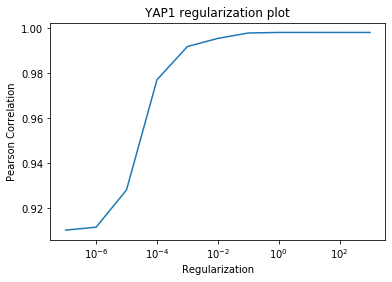

Optimized regularization term = 1.0e-03
CPU times: user 10.8 s, sys: 761 ms, total: 11.6 s
Wall time: 8.53 s


In [4]:
%%time
# Arguments input
TARGET_PROTEIN = 'YAP1'
REPLICATES = [1, 2] 
SITE_START, SITE_END = 1, 34
INPUT_DIR = './data/human_protein/YAP1/allele_counts/'                            # Allele counts file input directory
OUTPUT_DIR = './outputs/human_protein/YAP1/selection_coefficients/test/'    # Estimate selection coefficients file output directory
EPISTASIS = False
REGULARIZATION_PERCENT = 10

human_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# INPUT_FILE_PREFIX, FLAG_LIST, SITES = MPL.initialization(SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS)

# FREQUENCY_DIFF, COVARIANCE_MATRIX, MAX_READ = MPL_elements(FLAG_LIST, INPUT_DIR, REPLICATES, INPUT_FILE_PREFIX, SITES)


# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization(REGULARIZATION_LIST, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# FINAL_SELECTION = output_final_selection_human(REGULARIZATION_SELECTED, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# FINAL_SELECTION.to_csv(TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')

# DRB1

Reading single allele counts files from:
  ./data/human_protein/DRB1/allele_counts/single_allele_counts_rep1.csv
   delete 1649 rows of zero count records, remain 4751 rows of non zero count records
  ./data/human_protein/DRB1/allele_counts/single_allele_counts_rep2.csv
   delete 1701 rows of zero count records, remain 4699 rows of non zero count records
Reading double allele counts files from:
  ./data/human_protein/DRB1/allele_counts/double_allele_counts_rep1.csv
   delete 4527056 rows of zero count records, remain 388144 rows of non zero count records
  ./data/human_protein/DRB1/allele_counts/double_allele_counts_rep2.csv
   delete 4533803 rows of zero count records, remain 381397 rows of non zero count records
Getting single allele frequencies table:
Replicate 1
	Total 2950956 reads in generation 0
	Total 2984823 reads in generation 5
	Total 4543131 reads in generation 8
	Total 4489743 reads in generation 11
Replicate 2
	Total 2950956 reads in generation 0
	Total 2998596 reads in g

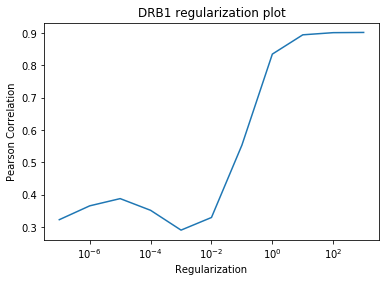

Optimized regularization term = 1.0e+01
CPU times: user 12.7 s, sys: 1.44 s, total: 14.2 s
Wall time: 12.2 s


In [9]:
%%time
# Arguments input
TARGET_PROTEIN = 'DRB1'
REPLICATES = [1, 2] 
SITE_START, SITE_END = 84, 108
INPUT_DIR = './data/human_protein/DRB1/allele_counts/'                            # Allele counts file input directory
OUTPUT_DIR = './outputs/human_protein/DRB1/selection_coefficients/'    # Estimate selection coefficients file output directory
EPISTASIS = False
REGULARIZATION_PERCENT = 10

human_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# INPUT_FILE_PREFIX, FLAG_LIST, SITES = MPL.initialization(SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS)

# FREQUENCY_DIFF, COVARIANCE_MATRIX, MAX_READ = MPL_elements(FLAG_LIST, INPUT_DIR, REPLICATES, INPUT_FILE_PREFIX, SITES)

# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization(REGULARIZATION_LIST, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)


# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# TpoR MPL

Reading single allele counts files from:
  ./data/human_protein/TpoR/TpoR_MPL/allele_counts/single_allele_counts_rep1.csv
   delete 426 rows of zero count records, remain 3542 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_MPL/allele_counts/single_allele_counts_rep2.csv
   delete 426 rows of zero count records, remain 3542 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_MPL/allele_counts/single_allele_counts_rep3.csv
   delete 426 rows of zero count records, remain 3542 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_MPL/allele_counts/single_allele_counts_rep4.csv
   delete 426 rows of zero count records, remain 3542 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_MPL/allele_counts/single_allele_counts_rep5.csv
   delete 426 rows of zero count records, remain 3542 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_MPL/allele_counts/single_allele_counts_rep6.csv
   delete 426 rows of zero count records, remain

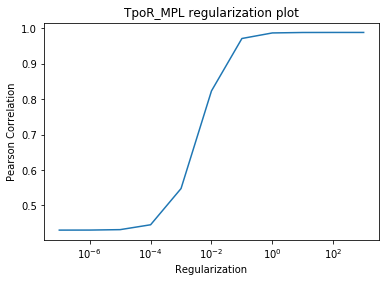

Optimized regularization term = 1.0e-01
CPU times: user 12.3 s, sys: 1.32 s, total: 13.6 s
Wall time: 7.98 s


In [10]:
%%time
# Arguments input
TARGET_PROTEIN = 'TpoR_MPL'
REPLICATES = [1, 2, 3, 4, 5, 6] 
SITE_START, SITE_END = 1, 31
INPUT_DIR = './data/human_protein/TpoR/TpoR_MPL/allele_counts/'                            # Allele counts file input directory
OUTPUT_DIR = './outputs/human_protein/TpoR/TpoR_MPL/selection_coefficients/'    # Estimate selection coefficients file output directory
EPISTASIS = False
REGULARIZATION_PERCENT = 10

human_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# INPUT_FILE_PREFIX, FLAG_LIST, SITES = MPL.initialization(SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS)

# FREQUENCY_DIFF, COVARIANCE_MATRIX, MAX_READ = MPL_elements(FLAG_LIST, INPUT_DIR, REPLICATES, INPUT_FILE_PREFIX, SITES)

# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization(REGULARIZATION_LIST, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)


# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# TpoR MPL S505N

Reading single allele counts files from:
  ./data/human_protein/TpoR/TpoR_S505NMPL/allele_counts/single_allele_counts_rep1.csv
   delete 474 rows of zero count records, remain 3494 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_S505NMPL/allele_counts/single_allele_counts_rep2.csv
   delete 474 rows of zero count records, remain 3494 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_S505NMPL/allele_counts/single_allele_counts_rep3.csv
   delete 474 rows of zero count records, remain 3494 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_S505NMPL/allele_counts/single_allele_counts_rep4.csv
   delete 474 rows of zero count records, remain 3494 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_S505NMPL/allele_counts/single_allele_counts_rep5.csv
   delete 474 rows of zero count records, remain 3494 rows of non zero count records
  ./data/human_protein/TpoR/TpoR_S505NMPL/allele_counts/single_allele_counts_rep6.csv
   delete 474 rows

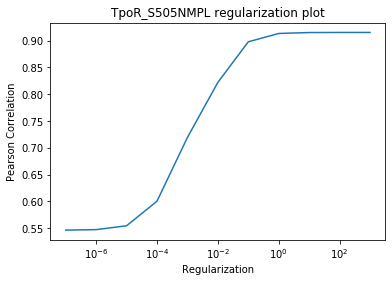

Optimized regularization term = 1.0e-01
CPU times: user 14.1 s, sys: 1.94 s, total: 16 s
Wall time: 9.07 s


In [12]:
%%time
# Arguments input
TARGET_PROTEIN = 'TpoR_S505NMPL'
REPLICATES = [1, 2, 3, 4, 5, 6] 
SITE_START, SITE_END = 1, 31
INPUT_DIR = './data/human_protein/TpoR/TpoR_S505NMPL/allele_counts/'                            # Allele counts file input directory
OUTPUT_DIR = './outputs/human_protein/TpoR/TpoR_S505NMPL/selection_coefficients/'    # Estimate selection coefficients file output directory
EPISTASIS = False
REGULARIZATION_PERCENT = 10

human_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# INPUT_FILE_PREFIX, FLAG_LIST, SITES = MPL.initialization(SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS)

# FREQUENCY_DIFF, COVARIANCE_MATRIX, MAX_READ = MPL_elements(FLAG_LIST, INPUT_DIR, REPLICATES, INPUT_FILE_PREFIX, SITES)

# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization(REGULARIZATION_LIST, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)


# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# Ube4b

Reading single allele counts files from:
  ./data/human_protein/Ube4b/allele_counts/single_allele_counts_rep1.csv
   delete 15980 rows of zero count records, remain 10388 rows of non zero count records
  ./data/human_protein/Ube4b/allele_counts/single_allele_counts_rep2.csv
   delete 15980 rows of zero count records, remain 10388 rows of non zero count records
Reading double allele counts files from:
  ./data/human_protein/Ube4b/allele_counts/double_allele_counts_rep1.csv
   delete 0 rows of zero count records, remain 1898584 rows of non zero count records
  ./data/human_protein/Ube4b/allele_counts/double_allele_counts_rep2.csv
   delete 0 rows of zero count records, remain 1898584 rows of non zero count records
Getting single allele frequencies table:
Replicate 1
	Total 7503842 reads in generation 0
	Total 4016296 reads in generation 1
	Total 9428941 reads in generation 2
	Total 10911032 reads in generation 3
Replicate 2
	Total 7503842 reads in generation 0
	Total 4408083 reads in gen

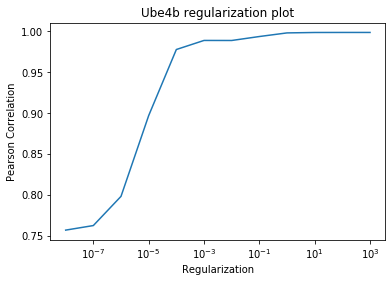

Optimized regularization term = 1.0e-04
CPU times: user 1min 36s, sys: 4.22 s, total: 1min 40s
Wall time: 1min 6s


In [13]:
%%time
# Arguments input
TARGET_PROTEIN = 'Ube4b'
REPLICATES = [1, 2] 
SITE_START, SITE_END = 1, 103
INPUT_DIR = './data/human_protein/Ube4b/allele_counts/'                            # Allele counts file input directory
OUTPUT_DIR = './outputs/human_protein/Ube4b/selection_coefficients/'    # Estimate selection coefficients file output directory
EPISTASIS = False
REGULARIZATION_PERCENT = 10

human_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# INPUT_FILE_PREFIX, FLAG_LIST, SITES = MPL.initialization(SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS)

# FREQUENCY_DIFF, COVARIANCE_MATRIX, MAX_READ = MPL_elements(FLAG_LIST, INPUT_DIR, REPLICATES, INPUT_FILE_PREFIX, SITES)

# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization(REGULARIZATION_LIST, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)


# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# Virus proteins

# Influenza PR8

------ Calculating single replicate selection coefficients for PR8 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of PR8:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of PR8:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_3 of PR8:
Correcting reads and computing allele frequency difference and mutational contribution...


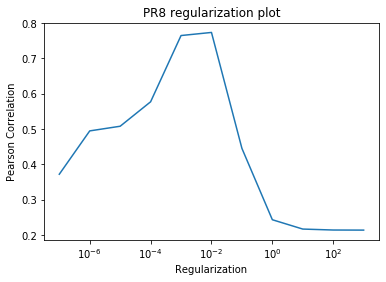

Optimized regularization term = 1.0e-03
CPU times: user 1min 21s, sys: 17.8 s, total: 1min 39s
Wall time: 39.6 s


In [4]:
%%time
INPUT_DIR      = './data/virus_protein/Aichi68C_PR8/PR8/raw_data'    
OUTPUT_DIR = './outputs/virus_protein/Aichi68C_PR8/PR8/selection_coefficients/'
SITE_START, SITE_END = 1, 498
REPLICATES     = [1, 2, 3]  
TARGET_PROTEIN = 'PR8'                 
MPL_DIR        = 'MPL'                              
PREFS_DIR      = ''                            
MPL_RAW_DIR    = ''   
EPISTASIS      = False
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10  

virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)



# Influenza Aichi68C

------ Calculating single replicate selection coefficients for Aichi68C ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of Aichi68C:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of Aichi68C:
Correcting reads and computing allele frequency difference and mutational contribution...


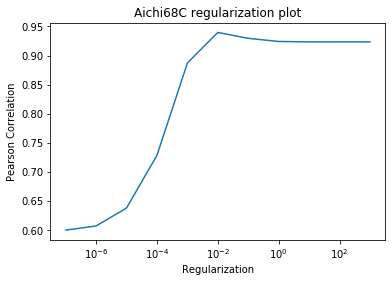

Optimized regularization term = 1.0e-02


In [5]:
INPUT_DIR      = './data/virus_protein/Aichi68C_PR8/Aichi68C/raw_data'    
OUTPUT_DIR = './outputs/virus_protein/Aichi68C_PR8/Aichi68C/selection_coefficients/'
SITE_START, SITE_END = 1, 498
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'Aichi68C'                 
MPL_DIR        = ''                              
PREFS_DIR      = ''    
EPISTASIS      = False
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10                                                   

virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# Influenza Matrix_M1

------ Calculating single replicate selection coefficients for Matrix_M1 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of Matrix_M1:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of Matrix_M1:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_3 of Matrix_M1:
Correcting reads and computing allele frequency difference and mutational contribution...


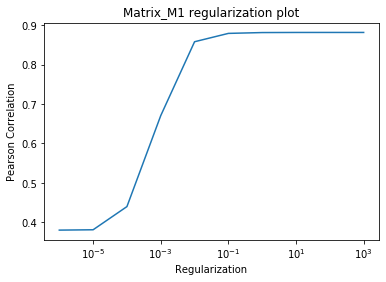

Optimized regularization term = 1.0e-02


In [6]:
INPUT_DIR      = './data/virus_protein/Matrix_M1/raw_data' 
OUTPUT_DIR     = './outputs/virus_protein/Matrix_M1/selection_coefficients/'
SITE_START, SITE_END = 1, 253
REPLICATES     = [1, 2, 3]                    
TARGET_PROTEIN = 'Matrix_M1'                 
MPL_DIR        = ''                              
PREFS_DIR      = '' 
EPISTASIS      = False
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10                                                   

virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# FINAL_SELECTION = output_final_selection_virus(REGULARIZATION_SELECTED, SITES, SITE_END, SITE_START, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# if os.path.exists(OUTPUT_DIR):
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')
# else:
#     os.makedirs(OUTPUT_DIR)
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')



# Influenza A549

------ Calculating single replicate selection coefficients for A549 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of A549:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of A549:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_3 of A549:
Correcting reads and computing allele frequency difference and mutational contribution...


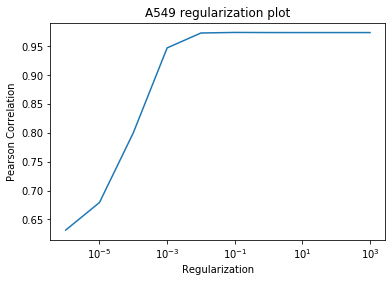

Optimized regularization term = 1.0e-03


In [7]:
INPUT_DIR      = './data/virus_protein/PB2/A549/raw_data' 
OUTPUT_DIR     = './outputs/virus_protein/PB2/A549/selection_coefficients/'
SITE_START, SITE_END = 1, 760
REPLICATES     = [1, 2, 3]                    
TARGET_PROTEIN = 'A549'                 
MPL_DIR        = ''                              
PREFS_DIR      = ''                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10 

virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# FINAL_SELECTION = output_final_selection_virus(REGULARIZATION_SELECTED, SITE_END, SITE_START, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# if os.path.exists(OUTPUT_DIR):
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')
# else:
#     os.makedirs(OUTPUT_DIR)
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')



# Influenza CCL141

------ Calculating single replicate selection coefficients for CCL141 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of CCL141:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of CCL141:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_3 of CCL141:
Correcting reads and computing allele frequency difference and mutational contribution...


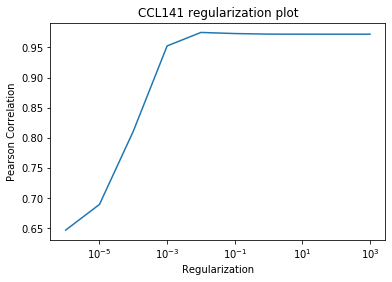

Optimized regularization term = 1.0e-03


In [8]:
INPUT_DIR      = './data/virus_protein/PB2/CCL141/raw_data' 
OUTPUT_DIR     = './outputs/virus_protein/PB2/CCL141/selection_coefficients/'
SITE_START, SITE_END = 1, 760
REPLICATES     = [1, 2, 3]                    
TARGET_PROTEIN = 'CCL141'                 
MPL_DIR        = ''                              
PREFS_DIR      = ''                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10    

virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)

# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# FINAL_SELECTION = output_final_selection_virus(REGULARIZATION_SELECTED, SITE_END, SITE_START, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# if os.path.exists(OUTPUT_DIR):
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')
# else:
#     os.makedirs(OUTPUT_DIR)
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')


# Influenza MS

------ Calculating single replicate selection coefficients for MS ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of MS:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of MS:
Correcting reads and computing allele frequency difference and mutational contribution...


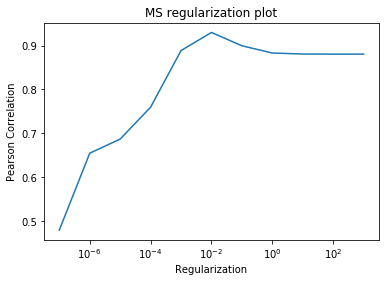

Optimized regularization term = 1.0e-03


In [9]:
INPUT_DIR      = './data/virus_protein/MxA/MS/raw_data'    
OUTPUT_DIR     = './outputs/virus_protein/MxA/MS/selection_coefficients/'
SITE_START, SITE_END = 1, 498
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'MS'                 
MPL_DIR        = ''                              
PREFS_DIR      = ''                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10                                                   

virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# FINAL_SELECTION = output_final_selection_virus(REGULARIZATION_SELECTED, SITE_END, SITE_START, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

# if os.path.exists(OUTPUT_DIR):
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')
# else:
#     os.makedirs(OUTPUT_DIR)
#     FINAL_SELECTION.to_csv(OUTPUT_DIR+TARGET_PROTEIN+'_'+'%d.csv.gz' %int(np.log10(REGULARIZATION_SELECTED)), index = False, compression = 'gzip')

# Influenza MxA

------ Calculating single replicate selection coefficients for MxA ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of MxA:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of MxA:
Correcting reads and computing allele frequency difference and mutational contribution...


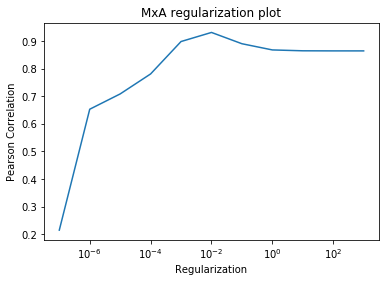

Optimized regularization term = 1.0e-03


In [10]:
INPUT_DIR      = './data/virus_protein/MxA/MxA/raw_data' 
OUTPUT_DIR     = './outputs/virus_protein/MxA/MxA/selection_coefficients/'
SITE_START, SITE_END = 1, 498
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'MxA'                 
MPL_DIR        = ''                              
PREFS_DIR      = ''                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10                                                   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# Influenza MxAneg

------ Calculating single replicate selection coefficients for MxAneg ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of MxAneg:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of MxAneg:
Correcting reads and computing allele frequency difference and mutational contribution...


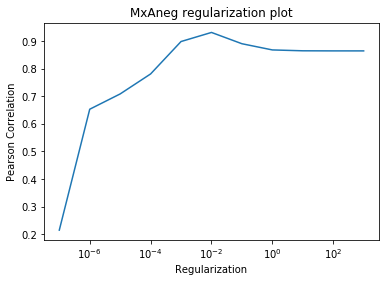

Optimized regularization term = 1.0e-03


In [11]:
INPUT_DIR      = './data/virus_protein/MxA/MxAneg/raw_data'  
OUTPUT_DIR     = './outputs/virus_protein/MxA/MxAneg/selection_coefficients/'
SITE_START, SITE_END = 1, 498
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'MxAneg'                 
MPL_DIR        = ''                              
PREFS_DIR      = '='                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10                                                   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# HIV Env BG505

------ Calculating single replicate selection coefficients for HIV Env BG505 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of HIV Env BG505:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of HIV Env BG505:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_3 of HIV Env BG505:
Correcting reads and computing allele frequency difference and mutational contribution...


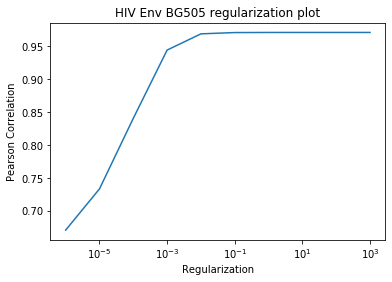

Optimized regularization term = 1.0e-03


In [12]:
INPUT_DIR      = './data/virus_protein/HIVEnv/BG505/raw_data' 
OUTPUT_DIR     = './outputs/virus_protein/HIVEnv/BG505/selection_coefficients/'
SITE_START, SITE_END = 1, 670
REPLICATES     = [1, 2, 3]                    
TARGET_PROTEIN = 'HIV Env BG505'                 
MPL_DIR        = 'MPL'                              
PREFS_DIR      = 'prefs'                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# HIV Env BF520

------ Calculating single replicate selection coefficients for HIV Env BF520 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of HIV Env BF520:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of HIV Env BF520:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_3 of HIV Env BF520:
Correcting reads and computing allele frequency difference and mutational contribution...


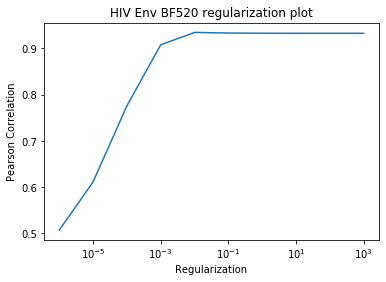

Optimized regularization term = 1.0e-03


In [13]:
INPUT_DIR      = './data/virus_protein/HIVEnv/BF520/raw_data'   
OUTPUT_DIR     = './outputs/virus_protein/HIVEnv/BF520/selection_coefficients/'
SITE_START, SITE_END = 1, 662
REPLICATES     = [1, 2, 3]                    
TARGET_PROTEIN = 'HIV Env BF520'                 
MPL_DIR        = ''                              
PREFS_DIR      = ''                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10                                                   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# HIV Env BF520 human host

------ Calculating single replicate selection coefficients for HIV BF520 human host ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of HIV BF520 human host:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of HIV BF520 human host:
Correcting reads and computing allele frequency difference and mutational contribution...


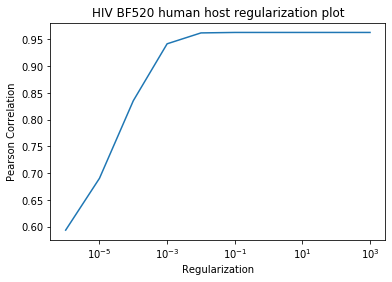

Optimized regularization term = 1.0e-03


In [14]:
INPUT_DIR      = './data/virus_protein/HIVEnv_CD4/BF520_human/raw_data' 
OUTPUT_DIR     = './outputs/virus_protein/HIVEnv_CD4/BF520_human/selection_coefficients/'
SITE_START, SITE_END = 1, 670
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'HIV BF520 human host'                 
MPL_DIR        = 'MPL'                              
PREFS_DIR      = 'prefs'                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10                                                   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)


# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# HIV Env BF520 rhesus host

------ Calculating single replicate selection coefficients for HIV BF520 rhesus host ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of HIV BF520 rhesus host:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of HIV BF520 rhesus host:
Correcting reads and computing allele frequency difference and mutational contribution...


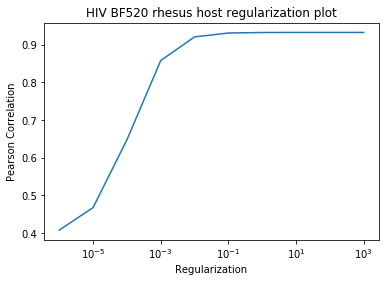

Optimized regularization term = 1.0e-02


In [15]:
INPUT_DIR      = './data/virus_protein/HIVEnv_CD4/BF520_rhesus/raw_data'  
OUTPUT_DIR     = './outputs/virus_protein/HIVEnv_CD4/BF520_rhesus/selection_coefficients/'
SITE_START, SITE_END = 1, 670
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'HIV BF520 rhesus host'                 
MPL_DIR        = 'MPL'                              
PREFS_DIR      = 'prefs'                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'              
REGULARIZATION_PERCENT = 10   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)



# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# HIV bnAbs FP16

------ Calculating single replicate selection coefficients for HIV bnAbs FP16 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of HIV bnAbs FP16:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of HIV bnAbs FP16:
Correcting reads and computing allele frequency difference and mutational contribution...


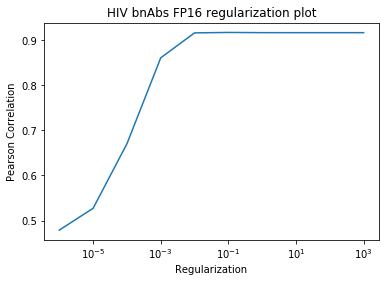

Optimized regularization term = 1.0e-02


In [5]:
INPUT_DIR      = './data/virus_protein/HIV_bnAbs/FP16/raw_data'  
OUTPUT_DIR     = './outputs/virus_protein/HIV_bnAbs/FP16/selection_coefficients/'
SITE_START, SITE_END = 1, 670
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'HIV bnAbs FP16'                 
MPL_DIR        = 'MPL'                              
PREFS_DIR      = 'prefs'                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'         
EPISTASIS      = False
REGULARIZATION_PERCENT = 10   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)



# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# HIV bnAbs FP20

------ Calculating single replicate selection coefficients for HIV bnAbs FP20 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of HIV bnAbs FP20:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of HIV bnAbs FP20:
Correcting reads and computing allele frequency difference and mutational contribution...


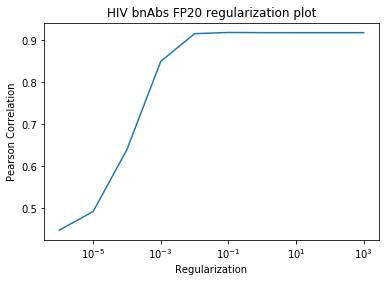

Optimized regularization term = 1.0e-02


In [6]:
INPUT_DIR      = './data/virus_protein/HIV_bnAbs/FP20/raw_data'  
OUTPUT_DIR     = './outputs/virus_protein/HIV_bnAbs/FP20/selection_coefficients/'
SITE_START, SITE_END = 1, 670
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'HIV bnAbs FP20'                 
MPL_DIR        = 'MPL'                              
PREFS_DIR      = 'prefs'                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'         
EPISTASIS      = False
REGULARIZATION_PERCENT = 10   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)



# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# HIV bnAbs VRC34

------ Calculating single replicate selection coefficients for HIV bnAbs VRC34 ------

Calculating error probability from DNA_codoncounts.csv...

Calculating selection coefficients for replicate_1 of HIV bnAbs VRC34:
Correcting reads and computing allele frequency difference and mutational contribution...
Calculating selection coefficients for replicate_2 of HIV bnAbs VRC34:
Correcting reads and computing allele frequency difference and mutational contribution...


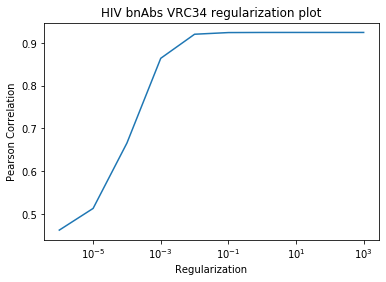

Optimized regularization term = 1.0e-02


In [7]:
INPUT_DIR      = './data/virus_protein/HIV_bnAbs/VRC34/raw_data'  
OUTPUT_DIR     = './outputs/virus_protein/HIV_bnAbs/VRC34/selection_coefficients/'
SITE_START, SITE_END = 1, 670
REPLICATES     = [1, 2]                    
TARGET_PROTEIN = 'HIV bnAbs VRC34'                 
MPL_DIR        = 'MPL'                              
PREFS_DIR      = 'prefs'                            
MPL_RAW_DIR    = 'raw_selection_coefficients'       
DNACODON       = 'DNA_codoncounts.csv'         
EPISTASIS      = False
REGULARIZATION_PERCENT = 10   
virus_pipeline(TARGET_PROTEIN, REPLICATES, SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS, REGULARIZATION_PERCENT)



# ESTIMATE_SELECTION, MAX_READ = MPL_virus_inference(TARGET_PROTEIN, DNACODON, REPLICATES, MPL_DIR, MPL_RAW_DIR)
# REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-1), 4)]
# CORRELATION_LIST = optimize_regularization_virus(ESTIMATE_SELECTION, REPLICATES, REGULARIZATION_LIST)
# plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, TARGET_PROTEIN)

# REGULARIZATION_SELECTED = find_best_regularization(REGULARIZATION_LIST, CORRELATION_LIST, REGULARIZATION_PERCENT)

# BRCA1 E3

This data set is large and the length of sequence is also long.

Reading single allele counts files from:
  ./data/human_protein/BRCA1/E3/allele_counts/single_allele_counts_rep1.csv
   delete 47374 rows of zero count records, remain 68978 rows of non zero count records
  ./data/human_protein/BRCA1/E3/allele_counts/single_allele_counts_rep2.csv
   delete 47682 rows of zero count records, remain 68670 rows of non zero count records
  ./data/human_protein/BRCA1/E3/allele_counts/single_allele_counts_rep3.csv
   delete 47086 rows of zero count records, remain 69266 rows of non zero count records
  ./data/human_protein/BRCA1/E3/allele_counts/single_allele_counts_rep4.csv
   delete 49200 rows of zero count records, remain 67152 rows of non zero count records
  ./data/human_protein/BRCA1/E3/allele_counts/single_allele_counts_rep5.csv
   delete 48482 rows of zero count records, remain 67870 rows of non zero count records
  ./data/human_protein/BRCA1/E3/allele_counts/single_allele_counts_rep6.csv
   delete 49846 rows of zero count records, remain 66506 rows o

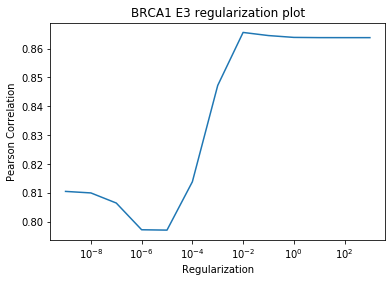

In [33]:
# Arguments input
REPLICATES = [1, 2, 3, 4, 5, 6] 
SITE_START, SITE_END = 1, 303
INPUT_DIR = './data/human_protein/BRCA1/E3/allele_counts/'                            # Allele counts file input directory
OUTPUT_DIR = './output/human_protein/BRCA1/E3/selection_coefficients/'    # Estimate selection coefficients file output directory
EPISTASIS = False

INPUT_FILE_PREFIX, FLAG_LIST, SITES = MPL.initialization(SITE_START, SITE_END, INPUT_DIR, OUTPUT_DIR, EPISTASIS)

FREQUENCY_DIFF, COVARIANCE_MATRIX, MAX_READ = MPL_elements(FLAG_LIST, INPUT_DIR, REPLICATES, INPUT_FILE_PREFIX, SITES)

REGULARIZATION_LIST = [np.power(10, float(i)) for i in range(int(np.log10(1/MAX_READ)-2), 4)]
CORRELATION_LIST = optimize_regularization(REGULARIZATION_LIST, SITES, COVARIANCE_MATRIX, FREQUENCY_DIFF, REPLICATES)

plot_reg_corr(REGULARIZATION_LIST, CORRELATION_LIST, 'BRCA1 E3')
